In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import scipy
import os

In [2]:
# project files

from utils.variables import pack, unpack
from utils.display import table, tabulate
from utils.files import download_sheet, save, load
from utils.hash import digest

from fit_options import fit_options
from game_model import game
from rp_model import compute_rp, make_precomputed_columns
from initial_guess import make_initial_guess


In [3]:
# stuff for display

from IPython.lib.pretty import pretty, pprint

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)

In [4]:
refresh_rp_file = True

rp_file_id = "1kBrPl0pdAO8gjOf_NrTgAPseFtqQA27fdfEbMBBeAhs"

sheet_ids = {
    "data_1_9":   "1682088244",
    "data_10_49": "1691041080",
}

if (refresh_rp_file):

    data_1_9 = download_sheet(rp_file_id, sheet_ids["data_1_9"])
    data_10_49 = download_sheet(rp_file_id, sheet_ids["data_10_49"])
    
    data = pd.concat([data_1_9, data_10_49], axis = 0)
    data.dropna(subset=["Pokemon","Level","RP","Nature","MS lvl"], inplace=True)
    data.fillna({'Amnt':0 ,'Ing2P':0, 'Help skill bonus': 1, 'RP Multiplier': 1, 'ModelRP': -1, 'Difference': -1}, inplace=True)
    data.fillna({'Sub Skill 1':'','Sub Skill 2':'', 'Ingredient 2': '', 'Source':''}, inplace=True)

    # data above 30 requires a 2nd ingredient to be valid.
    data.drop(  data.index[(data["Level"] >= 30) & (data["Amnt"] == 0.0)] , inplace=True )

    # data below 30 we clear 2nd ingredient
    data.loc[data["Level"] < 30, "Amnt"] = 0.0
    data.loc[data["Level"] < 30, "Ing2P"] = 0.0
    data.loc[data["Level"] < 30, "Ingredient 2"] = ""

    # data below 25 we clear 2nd skill, and below 10 we clear the 1st
    data.loc[data["Level"] < 25, "Sub Skill 2"] = ""
    data.loc[data["Level"] < 10, "Sub Skill 1"] = ""

    # avoid a bug in RP of freshly caught mon with skill up unlocked.
    # (We now trust the bugged data is quarantined so we can use the valid data)
    # data = data[ ~( (data["Sub Skill 1"] == "Skill Level Up S") & (data["MS lvl"] == 2) )]
    # data = data[ ~( (data["Sub Skill 1"] == "Skill Level Up M") & (data["MS lvl"] == 3) )]

    # only use data known to the Pokedex (we'll update Pokedex as needed)
    data.drop( data.index[~data["Pokemon"].isin( game.pokedex.data["Pokemon"]) ], inplace=True )
    
    data.to_pickle(fit_options.data_file)
    
else:
    
    data = pd.read_pickle(fit_options.data_file)


In [5]:
data.describe()
data.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,FreqL,Inv,Berry1,BerryL,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,BerryD,IngD,Dupes,Amnt,Ing2P,Help skill bonus,RP Multiplier
count,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.00000,6326.000000,6326.000000,6326.0,6326.000000,6326.000000,6326.000000,6326.000000
mean,10.600221,604.489251,1.490831,604.527087,0.037836,3957.192539,3807.605275,12.229529,28.040942,37.740120,108.840500,1.017855,0.988552,0.994790,1.000917,1.005375,0.207831,32.57993,55.241385,148.778375,1.0,0.072400,2.962536,0.987673,1.028040
std,7.144162,388.638606,0.982291,388.693660,0.962510,962.301896,1023.063474,3.385034,2.611147,8.005598,15.997332,0.303530,0.059303,0.044976,0.117870,0.118527,0.044906,36.08216,27.687375,60.605390,0.0,0.511503,20.447361,0.037609,0.070145
min,1.000000,245.000000,1.000000,245.060000,-11.980000,2200.000000,1489.118400,7.000000,24.000000,24.000000,90.000000,0.520000,0.890000,0.920000,0.800000,0.800000,0.130000,5.88000,25.000000,90.000000,1.0,0.000000,0.000000,0.790000,1.000000
25%,5.000000,355.000000,1.000000,354.635000,-0.280000,3300.000000,2955.960000,10.000000,26.000000,32.000000,98.000000,0.800000,1.000000,1.000000,1.000000,1.000000,0.180000,12.81000,35.000000,101.000000,1.0,0.000000,0.000000,1.000000,1.000000
50%,10.000000,462.000000,1.000000,461.845000,-0.010000,3900.000000,3792.400000,12.000000,28.000000,36.000000,103.000000,0.940000,1.000000,1.000000,1.000000,1.000000,0.200000,19.98000,45.000000,121.000000,1.0,0.000000,0.000000,1.000000,1.000000
75%,14.000000,712.000000,2.000000,711.970000,0.270000,4500.000000,4455.000000,14.000000,31.000000,42.000000,115.000000,1.210000,1.000000,1.000000,1.000000,1.000000,0.240000,43.98000,68.000000,202.000000,1.0,0.000000,0.000000,1.000000,1.000000
max,42.000000,3440.000000,6.000000,3440.430000,10.460000,6300.000000,6916.140000,23.000000,35.000000,77.000000,151.000000,2.410000,1.120000,1.080000,1.200000,1.200000,0.420000,413.95000,222.000000,511.000000,1.0,8.000000,342.000000,1.000000,1.440000


,Pokemon,Level,RP,Nature,MS lvl,Source,ModelRP,Difference,Nature2,ID,NatureP,NatureN,Freq1,FreqL,Type,Class,MSkill,Inv,Berry1,BerryL,Ing1,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,RPneutral,IDNeutral,BerryD,IngD,Dupes,DupeMatch,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,Help skill bonus,RP Multiplier
0,Arbok,9.0,574.0,Naughty,1.0,Rate My Mon,574.42,0.42,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,3700.0,3276.72,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,1.09,0.90,1.00,1.0,0.8,0.26,22.76,538.36,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
1,Arbok,8.0,531.0,Hardy,1.0,Questions help guides,530.70,-0.30,Neutral,ArbokNeutral81,-,-,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.0,1.0,0.26,22.76,531.00,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
2,Arbok,8.0,538.0,Quiet,1.0,Questions help guides,538.09,0.09,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.2,1.0,0.26,22.76,530.61,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
3,Arcanine,5.0,958.0,Calm,3.0,,957.90,-0.10,Calm,ArcanineCalm53,Main Skill Chance,Speed of Help,2500.0,2728.00,Fire,Skills,Extra Helpful S,16.0,27.0,31,Fiery Herb,130.0,1.31,1.11,1.00,1.0,1.2,0.14,84.50,937.84,ArcanineNeutral53,31.0,130.0,1,True,,,,0.0,0.0,1.0,1.0
4,Arcanine,3.0,715.0,Lax,2.0,pokemon sleep general,714.77,-0.23,Lax,ArcanineLax32,Energy Recovery,Main Skill Chance,2500.0,2490.00,Fire,Skills,Extra Helpful S,16.0,27.0,29,Fiery Herb,130.0,1.44,1.00,1.08,1.0,0.8,0.14,61.21,750.21,ArcanineNeutral32,29.0,130.0,1,True,,,,0.0,0.0,1.0,1.0


In [6]:
# Make an initial guess
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector

x0, unpack_info = pack(make_initial_guess())


In [7]:
# Compute per sample information about help time, nature, sub-skills etc
computed = make_precomputed_columns(data)

# Do we match the sheet? Yes
(computed.helps_per_hour - data["Helps per hour"]).describe()

count    6326.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: Helps per hour, dtype: float64

In [8]:
# We compute the RP model in rp_model.py
# Here we create closure to glue the pieces together.

def RP(x):
    return compute_rp(x, data, computed, unpack_info)

def residual(x):
    return data["RP"].to_numpy() - RP(x)

count    6326.000000
mean        4.075087
std         3.498059
min         0.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        34.000000
Name: RP, dtype: float64

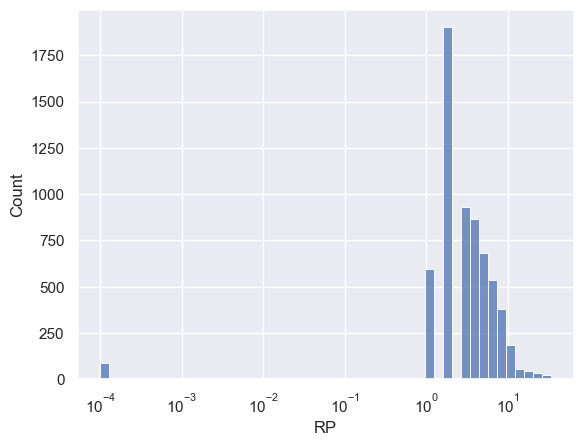

In [9]:
# what is the quality of the initial guess?

r = np.abs(data["RP"] - np.round(RP(x0)) )
pd.Series(r).describe()
_ = sns.histplot(x=np.clip(r, 1e-4,1e3), log_scale=True, bins=50)

In [10]:
cache_fit = True

# least_squares gives a deterministic result that depends on x0, the data, and the optimizer options
# hash the data as well as x0 to decide if we reuse last fit

filename = fit_options.result_file(digest(data, x0))

if cache_fit and os.path.isfile(filename):
    opt = load(filename)
    print("Loaded from cache")
else:

    # We use approximate rounding to keep derivatives intact
    fit_options.soft_round.exact = False
    fit_options.soft_round.alpha = 6
    opt = scipy.optimize.least_squares(residual, x0, **fit_options.least_squares_kwargs)

    fit_options.soft_round.alpha = 12
    opt = scipy.optimize.least_squares(residual, opt.x, **fit_options.least_squares_kwargs)

    fit_options.soft_round.alpha = 18
    opt = scipy.optimize.least_squares(residual, opt.x, **fit_options.least_squares_kwargs)


    
    # save results and remove some stuff we don't need to save.
    if 'jac' in opt: del opt.jac
    if 'active_mask' in opt: del opt.active_mask
    if 'fun' in opt: del opt.fun
    if 'final_simplex' in opt: del opt.final_simplex

    save(filename, opt)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.1661e+04                                    1.99e+09    
       1             10         6.3258e+04      1.84e+04       5.22e-03       1.09e+09    
       2             11         2.5097e+04      3.82e+04       1.30e-03       8.03e+08    
       3             12         1.2070e+04      1.30e+04       2.61e-03       3.96e+08    
       4             13         7.2830e+03      4.79e+03       5.22e-03       1.58e+08    
       5             14         5.3637e+03      1.92e+03       1.04e-02       9.42e+07    
       6             15         5.1251e+03      2.39e+02       2.09e-02       7.00e+06    
       7             16         4.2980e+03      8.27e+02       5.22e-03       2.94e+07    
       8             17         4.0349e+03      2.63e+02       1.04e-02       2.77e+07    
       9             18         3.9675e+03      6.74e+01       1.04e-02       5.56e+06    

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in scalar divide
  ratio = phi / phi_prime


In [11]:
opt

    message: The maximum number of function evaluations is exceeded.
    success: False
     status: 0
          x: [ 2.521e-01  2.502e-01 ...  2.199e-01  2.199e-01]
       cost: 4144.405211938394
       grad: [ 1.476e+03  4.234e+03 ... -9.749e+03 -7.575e+04]
 optimality: 9211562.42645229
       nfev: 200
       njev: 14

count    6326.000000
mean        0.488144
std         1.048893
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        20.000000
Name: RP, dtype: float64

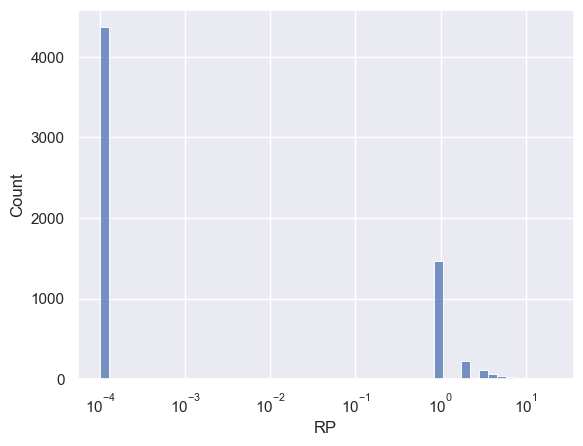

In [12]:
r_opt = np.abs(data["RP"] - np.round(RP(opt.x)) )
pd.Series(r_opt).describe()
_ = sns.histplot(x=np.clip(r_opt, 1e-4,1e3), log_scale=True, bins=50)

In [13]:
sol = unpack(opt.x, unpack_info)

table(sol)

Pokemons ing fractions,[0.25205608 0.25017909 0.26137078 ... 0.17699264 0.19652334 0.20934654]
Pokemons skill products,[16.82007973 16.78008548 18.45008895 ... 44.88927689 13.03999414 16.29995702]
Charge Strength S,[0.74791098 0.32204956]
Charge Strength M,[0.74632239 0.32268268]
Ingredient Magnet S,[0.74643803 0.32257535]
Cooking Power-Up S,[0.74593821 0.3227074 ]
Extra Helpful S,[0.7471663 0.32219216]
Charge Energy S,[0.74585613 0.32286112]
Energizing Cheer S,[0.74352146 0.32603416]
Energy for Everyone S,[0.74622735 0.32275905]
Dream Shard Magnet S,[0.73286421 0.3301134 ]


In [14]:
# Format ing% and skillProduct pretty

res = pd.DataFrame({"Pokemon":game.pokedex.data["Pokemon"], "ing%": sol["Pokemons ing fractions"]*100.0, "skill% * skillValue": sol["Pokemons skill products"] })
res.set_index("Pokemon")

,ing%,skill% * skillValue
Pokemon,,
Bulbasaur,25.205608,16.820080
Ivysaur,25.017909,16.780085
Venusaur,26.137078,18.450089
Charmander,19.705890,9.790013
Charmeleon,22.279635,14.110291
Charizard,22.029204,14.071673
Squirtle,26.558786,17.690077
Wartortle,26.580624,17.680069
Blastoise,26.969171,18.499200


In [15]:
# Format main skill growth per level 

growth_display = {}
levels = np.array(list(range(2,7)))
growth_display["Level"] = levels

for record in game.mainskills.data.to_dict(orient='records') :   
    
    skillname = record["Skill"]
    params = sol[skillname]
    growth_display[skillname] = params[0]*np.exp(params[1]*levels)
    
df = pd.DataFrame(growth_display)
df.set_index("Level")


,Charge Strength S,Charge Strength M,Ingredient Magnet S,Cooking Power-Up S,Extra Helpful S,Charge Energy S,Energizing Cheer S,Energy for Everyone S,Dream Shard Magnet S,Metronome
Level,,,,,,,,,,
2,1.424225,1.423001,1.422916,1.422338,1.423213,1.422619,1.427195,1.423037,1.418262,1.422498
3,1.965364,1.964918,1.964590,1.964052,1.964247,1.964742,1.977325,1.965118,1.972981,1.964750
4,2.712110,2.713212,2.712467,2.712083,2.710955,2.713453,2.739510,2.713695,2.744664,2.713705
5,3.742585,3.746477,3.745047,3.745011,3.741525,3.747478,3.795489,3.747430,3.818173,3.748160
6,5.164592,5.173236,5.170707,5.171340,5.163866,5.175543,5.258508,5.174948,5.311560,5.176946


In [16]:
# We have an issue where soft_floor(22) will always be 21.5 regardless of alpha.
# So either we keep soft_floor in the final model... or we transform the fitted values?
# If we can use round() instead of floor() this problem would not be here.

from utils.soft_round import soft_floor
bonus = dict(filter( lambda x: x[0] in game.subskills.bonus_names, sol.items()))

for key in bonus.keys():
    bonus[key] = soft_floor(100*bonus[key])/100

table(bonus)

Dream Shard Bonus,0.213571
Energy Recovery Bonus,0.215984
Helping bonus,0.213885
Inventory Up S,0.0656756
Inventory Up M,0.126817
Inventory Up L,0.174674
Research EXP Bonus,0.214521
Sleep EXP Bonus,0.214282


In [17]:
# What are the worst points?

df = data[["Pokemon","ID","Level","MS lvl","NatureP","NatureN","Sub Skill 1","Sub Skill 2","RP"]].copy()

df["fit"] = RP(opt.x)
df["error"] = residual(opt.x)
df["error2"] = df["error"]**2

df = df.sort_values("error2", ascending = False)
df.head(100)

,Pokemon,ID,Level,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
2556,Swalot,SwalotNeutral254Helping bonusSkill Trigger M,25.0,4.0,-,-,Helping bonus,Skill Trigger M,1768.0,1788.013309,-20.013309,400.532540
2609,Togekiss,TogekissGentle275Research EXP BonusHelping bonus,27.0,5.0,Main Skill Chance,Energy Recovery,Research EXP Bonus,Helping bonus,2651.0,2663.012368,-12.012368,144.296991
2569,Sylveon,SylveonGentle256Helping bonusSkill Level Up M,25.0,6.0,Main Skill Chance,Energy Recovery,Helping bonus,Skill Level Up M,2757.0,2769.000001,-12.000001,144.000025
398,Charizard,CharizardMild276Helping Speed MSkill Level Up M,27.0,6.0,Ingredient Finding,Energy Recovery,Helping Speed M,Skill Level Up M,1514.0,1502.925959,11.074041,122.634390
2607,Togekiss,TogekissGentle245Research EXP Bonus,24.0,5.0,Main Skill Chance,Energy Recovery,Research EXP Bonus,,2208.0,2218.000003,-10.000003,100.000054
2603,Togekiss,TogekissGentle103Skill Trigger M,10.0,3.0,Main Skill Chance,Energy Recovery,Skill Trigger M,,1282.0,1272.000000,10.000000,100.000000
2727,Typhlosion,TyphlosionCareful273Berry Finding SHelping Spe...,27.0,3.0,Main Skill Chance,Ingredient Finding,Berry Finding S,Helping Speed M,1761.0,1751.000037,9.999963,99.999253
178,Blastoise,BlastoiseGentle324Skill Trigger MSleep EXP Bonus,32.0,4.0,Main Skill Chance,Energy Recovery,Skill Trigger M,Sleep EXP Bonus,1878.0,1887.000034,-9.000034,81.000610
427,Charizard,CharizardRash273Helping bonusHelping Speed M,27.0,3.0,Ingredient Finding,Main Skill Chance,Helping bonus,Helping Speed M,1440.0,1430.999999,9.000001,81.000024
2801,Victreebel,VictreebelNeutral313Energy Recovery BonusInven...,31.0,3.0,-,-,Energy Recovery Bonus,Inventory Up M,1713.0,1704.000267,8.999733,80.995192
